
# Baseline Random Forest


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# =======================
# 1. Data Loading and EDA
# =======================

In [3]:
# Load dataset
print("Loading dataset...")
#df = pd.read_csv('ACDC_radiomics.csv')
df = pd.read_csv('../datasets/ACDC_radiomics.csv')

Loading dataset...


In [4]:
# Basic EDA
print("\n=== Dataset Overview ===")
print(f"Shape: {df.shape}")
print(f"Classes:\n{df['class'].value_counts()}")



=== Dataset Overview ===
Shape: (100, 645)
Classes:
class
DCM     20
HCM     20
MINF    20
NOR     20
RV      20
Name: count, dtype: int64


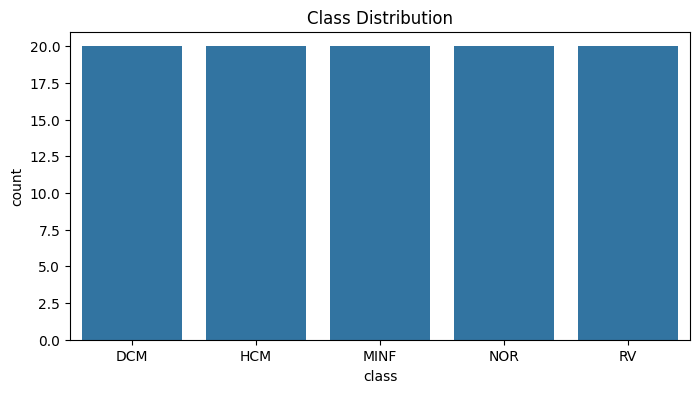

<Figure size 640x480 with 0 Axes>

In [5]:
# Visualize class distribution
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='class')
plt.title('Class Distribution')
plt.show()  # Display in notebook
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')  # Save

# ===============
# 2. Data Preprocessing
# ===============

In [6]:
# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

# Train-Validation-Test Split (70-15-15)
print("\nSplitting data...")
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Splitting data...


# ============
# 3. Baseline Model
# ============

In [7]:
print("\nTraining Random Forest...")
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)
rf.fit(X_train_scaled, y_train)


Training Random Forest...


RandomForestClassifier(class_weight='balanced', random_state=42)

# =========
# 4. Evaluation
# =========

In [8]:
def evaluate_model(model, X, y, dataset_name):
    """Helper function for evaluation"""
    y_pred = model.predict(X)
    print(f"\n=== {dataset_name} Performance ===")
    print(classification_report(y, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=model.classes_)
    disp.plot()
    plt.title(f'Confusion Matrix ({dataset_name})')
    plt.savefig(f'confusion_matrix_{dataset_name}.png', dpi=300)
    plt.close()

# Evaluate on all sets
evaluate_model(rf, X_train_scaled, y_train, "Training")
evaluate_model(rf, X_val_scaled, y_val, "Validation")
evaluate_model(rf, X_test_scaled, y_test, "Test")



=== Training Performance ===
              precision    recall  f1-score   support

         DCM       1.00      1.00      1.00        14
         HCM       1.00      1.00      1.00        14
        MINF       1.00      1.00      1.00        14
         NOR       1.00      1.00      1.00        14
          RV       1.00      1.00      1.00        14

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70


=== Validation Performance ===
              precision    recall  f1-score   support

         DCM       1.00      1.00      1.00         3
         HCM       1.00      1.00      1.00         3
        MINF       1.00      0.67      0.80         3
         NOR       0.75      1.00      0.86         3
          RV       1.00      1.00      1.00         3

    accuracy                           0.93        15
   macro avg       0.95      0.93      0.93        15
weighted avg   

=========================================================================================================

The Random Forest Classifier achieves perfect performance on the training set, with 100% precision, recall, and F1-scores across all classes, which is a strong indicator of overfitting. On the validation set, performance remains high with an accuracy of 93%, although minor drops in recall for classes like MINF and NOR suggest the model may be starting to struggle with generalization. This trend becomes more evident on the test set, where the accuracy decreases to 80%. Classes such as HCM and NOR show noticeably lower recall and F1-scores, with NOR exhibiting high precision but low recall, indicating that while predicted NOR cases are mostly correct, many true NOR instances are missed. In contrast, MINF and RV maintain excellent performance. These results suggest that while the Random Forest handles training data exceptionally well, it may require tuning or additional regularization to improve its generalization to unseen data.

===============
# 5. Feature Importance analysis for the baseline


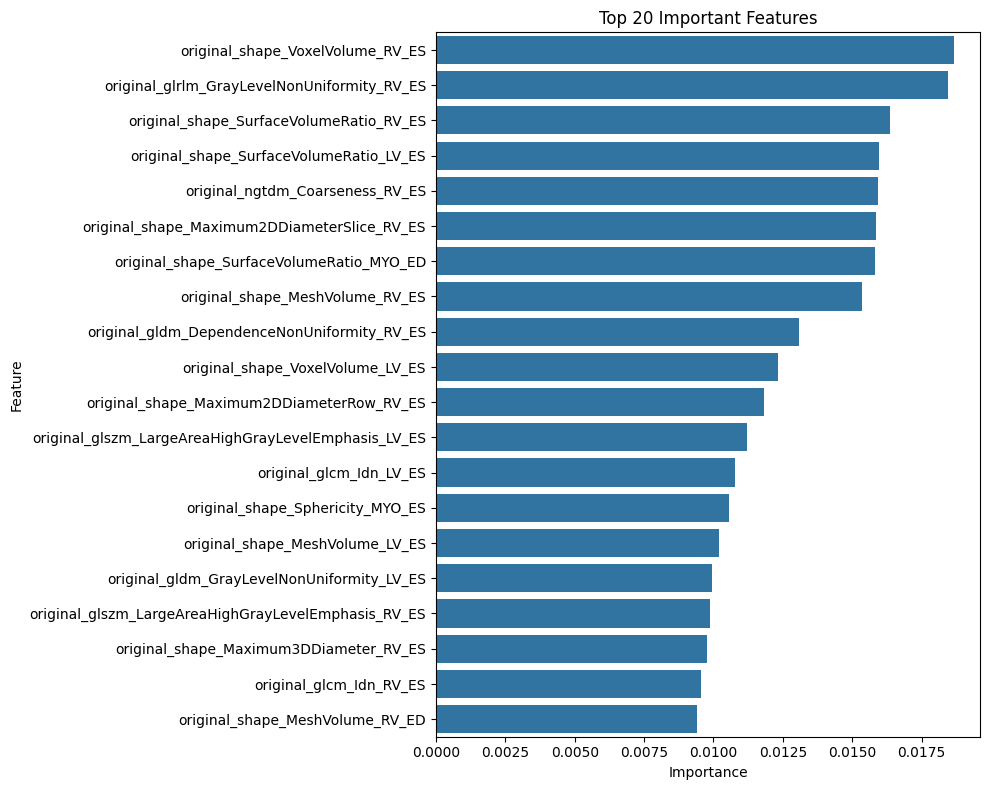

In [9]:
# Get feature importances
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(data=importances.head(20), y='Feature', x='Importance')
plt.title('Top 20 Important Features')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)

# Save important features
importances.to_csv('feature_importances.csv', index=False)

# Applying mRMR feature to the ACDC_radiomics dataset

In [1]:
import pandas as pd
import numpy as np
import mrmr
#from mrmr import mrmr_classif
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# 1. Loading ACDC_radiomics dataset
data = pd.read_csv('../datasets/ACDC_radiomics.csv')
X = data.drop(['class'], axis=1)  # Features
y = data['class']  # Target variable 

# 2. Normalize the features (important for mRMR)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 3. Apply mRMR feature selection
selected_features = mrmr.mrmr_classif(
    X=X_scaled, 
    y=y, 
    K=20,  # number of features to select
    relevance='f',  # 'f' for F-test, 'corr' for Pearson correlation
    redundancy='c',  # 'c' for correlation
    denominator='mean',  # how to combine relevance and redundancy
    show_progress=True
)

print("Selected Features:", selected_features)

# 4. Evaluate the selected features
# Before feature selection
clf = RandomForestClassifier(random_state=42)
scores = cross_val_score(clf, X_scaled, y, cv=5, scoring='accuracy')
print(f"\n Original Accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# After feature selection
clf = RandomForestClassifier(random_state=42)
scores = cross_val_score(clf, X_scaled[selected_features], y, cv=5, scoring='accuracy')
acc_rf_rmr = scores
print(f"\n mRMR Selected Accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# 5. Get the reduced feature set
X_reduced = X_scaled[selected_features]

100%|██████████| 20/20 [00:01<00:00, 11.67it/s]


Selected Features: ['original_shape_MeshVolume_RV_ES', 'original_gldm_DependenceNonUniformityNormalized_LV_ED', 'original_glcm_MCC_LV_ED', 'original_shape_VoxelVolume_RV_ES', 'original_shape_MinorAxisLength_RV_ES', 'original_shape_LeastAxisLength_LV_ES', 'original_shape_SurfaceVolumeRatio_MYO_ED', 'original_shape_Maximum2DDiameterSlice_RV_ES', 'original_shape_SurfaceVolumeRatio_LV_ES', 'original_shape_Sphericity_MYO_ES', 'original_shape_SurfaceVolumeRatio_RV_ES', 'original_glcm_Imc1_MYO_ES', 'original_shape_MajorAxisLength_RV_ES', 'original_shape_Elongation_MYO_ES', 'original_shape_Maximum2DDiameterRow_RV_ES', 'original_shape_LeastAxisLength_LV_ED', 'original_glrlm_RunLengthNonUniformity_RV_ES', 'original_gldm_GrayLevelNonUniformity_LV_ES', 'original_glrlm_GrayLevelNonUniformity_RV_ES', 'original_shape_SurfaceVolumeRatio_MYO_ES']

 Original Accuracy: 0.760 ± 0.073

 mRMR Selected Accuracy: 0.810 ± 0.080


================================================================================================================================

Results suggest that the application of mRMR feature selection using the mrmr_selection package led to a noticeable improvement in model performance, increasing the classification accuracy from 0.760 ± 0.073 with the original feature set to 0.810 ± 0.080 using the selected features. This indicates that the selected 20 features were more relevant and less redundant, enabling the model to capture the underlying patterns in the data better. The improved accuracy and similar variability suggest that mRMR enhanced predictive power and maintained model stability, making it a valuable step in the preprocessing pipeline for this dataset.

# Random Forest + mRMR Features (Reduced features) + y_enc.npy (Encoded Labels)

In [3]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score

# 1. Load encoded labels
y_enc = np.load('../datasets/y_enc.npy')

# 2. Define classifier
clf = RandomForestClassifier(random_state=42)

# 3. Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Accuracy and F1 evaluation
acc_scores = cross_val_score(clf, X_reduced, y_enc, cv=cv, scoring='accuracy')
acc_rf_rmr_enc = acc_scores
f1_scores = cross_val_score(clf, X_reduced, y_enc, cv=cv, scoring=make_scorer(f1_score, average='macro'))

# 5. Results
print("Random Forest with mRMR Features (using y_enc)")
print(f"Accuracy scores: {acc_scores}")
print(f"F1 scores: {f1_scores}")
print(f"Mean Accuracy: {np.mean(acc_scores):.3f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.3f}")


Random Forest with mRMR Features (using y_enc)
Accuracy scores: [0.65 0.9  0.8  0.85 0.85]
F1 scores: [0.63353535 0.8984127  0.79619048 0.85396825 0.84253968]
Mean Accuracy: 0.810
Mean F1 Score: 0.805



Interpretation of the Random Forest model using mRMR-selected features
================================

The Random Forest classifier using mRMR-selected features and encoded labels (y_enc) achieved strong performance, with an average accuracy of 81% and a macro-averaged F1 score of 0.805 across 5-fold cross-validation. This indicates that the mRMR selection process was effective in retaining informative and minimally redundant features, enabling the model to maintain high predictive performance despite a reduced feature space. 



# Now let us look at the PCA Random Forest-based model. We shall use the X_PCA_16.npy (Reduced features) set and y_enc.npy (Encoded labels)

1. Data loading and preparation

In [6]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Loading PCA-reduced features and encoded labels
X_pca = np.load('../datasets/X_pca_16.npy')  # our PCA_reduced feature
y = np.load('../datasets/y_enc.npy')   # our encoded labes

# Checking shapes
print(f"X_pca shape: {X_pca.shape}")
print(f"y shape: {y.shape}")

# If y is one-hot encoded, convert to labels
if len(y.shape) > 1 and y.shape[1] > 1:
    y = np.argmax(y, axis=1)

X_pca shape: (100, 16)
y shape: (100,)


2. Train-Test split

In [7]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shapes: {X_train.shape}, {y_train.shape}")
print(f"Test shapes: {X_test.shape}, {y_test.shape}")

Train shapes: (80, 16), (80,)
Test shapes: (20, 16), (20,)


3. Random Forest Classifier implementation

In [8]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define the model
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# Set up StratifiedKFold with 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run cross-validation with multiple scoring metrics
cv_results = cross_validate(
    rf,
    X_pca,            # our PCA-reduced features
    y,                # Corresponding labels
    cv=skf,           # Using stratified folds
    n_jobs=-1,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro'
    },
    return_train_score=False
)

# Print the results
print(f"Cross-validation accuracy scores: {cv_results['test_accuracy']}")
acc_rf_pca_enc = cv_results['test_accuracy']
print(f"Cross-validation F1 scores (macro): {cv_results['test_f1_macro']}")
print(f"Cross-validation Precision scores (macro): {cv_results['test_precision_macro']}")
print(f"Cross-validation Recall scores (macro): {cv_results['test_recall_macro']}")

print(f"\nMean CV Accuracy: {np.mean(cv_results['test_accuracy']):.3f} ± {np.std(cv_results['test_accuracy']):.3f}")
print(f"Mean CV F1 Score (macro): {np.mean(cv_results['test_f1_macro']):.3f} ± {np.std(cv_results['test_f1_macro']):.3f}")
print(f"Mean CV Precision (macro): {np.mean(cv_results['test_precision_macro']):.3f} ± {np.std(cv_results['test_precision_macro']):.3f}")
print(f"Mean CV Recall (macro): {np.mean(cv_results['test_recall_macro']):.3f} ± {np.std(cv_results['test_recall_macro']):.3f}")


Cross-validation accuracy scores: [0.7  0.6  0.7  0.85 0.7 ]
Cross-validation F1 scores (macro): [0.66888889 0.59238095 0.69095238 0.8484127  0.69095238]
Cross-validation Precision scores (macro): [0.74       0.63333333 0.73666667 0.87       0.73666667]
Cross-validation Recall scores (macro): [0.7  0.6  0.7  0.85 0.7 ]

Mean CV Accuracy: 0.710 ± 0.080
Mean CV F1 Score (macro): 0.698 ± 0.083
Mean CV Precision (macro): 0.743 ± 0.075
Mean CV Recall (macro): 0.710 ± 0.080



=================================================================================================================
The cross-validation outcomes of the PCA-based Random Forest model show moderately strong and consistent performance throughout the folds. On average, the model attained a mean accuracy of 0.710 ± 0.080, indicating it accurately classified about 71% of instances, with reasonable variation among different data splits. The macro-averaged F1 score of 0.698 ± 0.083 demonstrates balanced performance across all classes, implying that the model achieves a good balance between precision and recall, even in multi-class situations. Precision was slightly higher, averaging 0.743 ± 0.075, indicating the model's effectiveness in reducing false positives. The recall mirrored the accuracy at 0.710 ± 0.080, suggesting that the model effectively captures a significant proportion of true class labels. Overall, the results point to a well-performing model with consistent behavior across folds, benefiting from the class balance provided by StratifiedKFold.
Notably, the Random Forest classifier using mRMR-selected features and encoded labels (y_enc) outperformed the PCA + Random Forest variant (71% accuracy, 0.70 F1) and was comparable to the full-feature Baseline Random Forest (80% accuracy, 0.78 F1), suggesting that mRMR not only compresses the data but can also enhance generalization by focusing on the most relevant features.

 ===================
 
# PCA Feature Importance Analysis

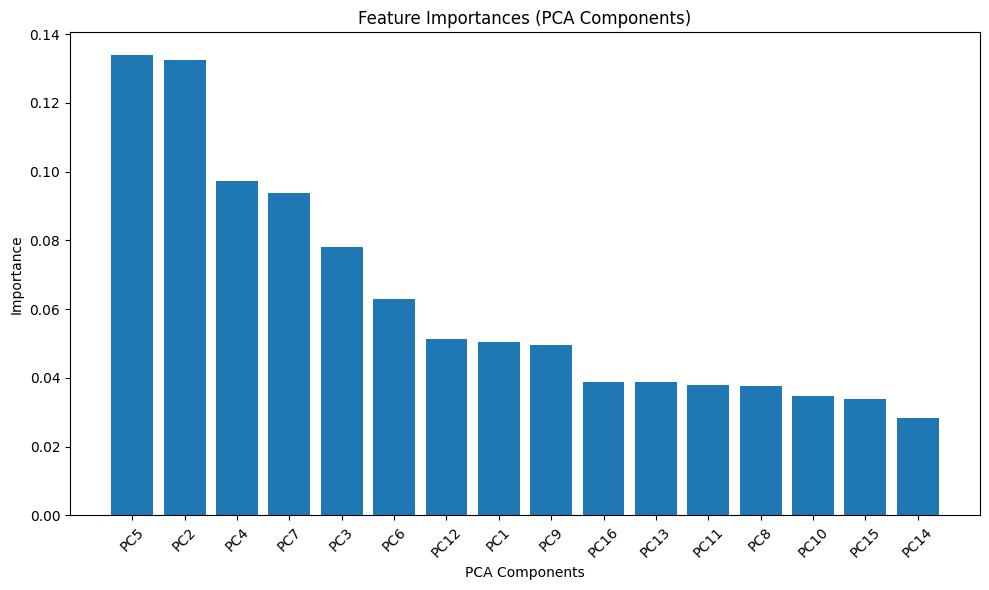

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Fit model on the PCA-reduced data (just to be sure)
rf.fit(X_pca, y)

# Get feature importances from the trained Random Forest
importances = rf.feature_importances_

# Creating labels for PCA components (e.g., PC1, PC2, ...)
feature_names = [f'PC{i+1}' for i in range(X_pca.shape[1])]

# Sort importances
indices = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(X_pca.shape[1]), sorted_importances, align='center')
plt.xticks(range(X_pca.shape[1]), sorted_features, rotation=45)
plt.title('Feature Importances (PCA Components)')
plt.xlabel('PCA Components')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


5. Hyperparameter tuning

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

# Define parameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Define multiple scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro'
}

# Set up stratified k-fold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring=scoring,
    refit='f1_macro',  # Tune based on best macro F1 score
    cv=cv_strategy,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Run grid search on PCA-reduced data
grid_search.fit(X_pca, y)

# Show best parameters
print("\n Best Parameters Based on F1 Macro:")
print(grid_search.best_params_)

# Retrieve and show results in a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)
metrics_cols = [col for col in results_df.columns if 'mean_test' in col or 'params' in col]

print("\n Grid Search Results (sorted by mean_test_f1_macro):")
print(results_df.sort_values(by='mean_test_f1_macro', ascending=False)[metrics_cols].to_string(index=False))


Fitting 5 folds for each of 24 candidates, totalling 120 fits

 Best Parameters Based on F1 Macro:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

 Grid Search Results (sorted by mean_test_f1_macro):
                                                                                 params  mean_test_accuracy  mean_test_f1_macro  mean_test_precision_macro  mean_test_recall_macro
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}                0.72            0.713882                   0.771810                    0.72
  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}                0.72            0.713882                   0.771810                    0.72
  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}                0.71            0.702929                   0.765810                    0.71
{'max_depth': None, 'min_samples_leaf': 1, 

=========================================================================================================

The grid search results indicate that the best-performing model has parameters max_depth=None, min_samples_leaf=1, min_samples_split=2, and n_estimators=200, achieving the highest F1 Macro score of 0.71388. This model also performs well in terms of accuracy (0.72), precision (0.77181), and recall (0.72). The second-best models, which have similar F1 scores, include those with max_depth=20 and n_estimators=200, as well as max_depth=10 with n_estimators=200. These models yield slightly lower scores but still demonstrate strong performance. Models with max_depth=None and min_samples_leaf=2 performed somewhat lower in comparison but maintained a robust F1 Macro of around 0.7, suggesting that slightly deeper trees or those with more leaf samples may reduce model complexity without significantly compromising performance. In conclusion, the best model achieves a good balance between complexity and performance, attaining high F1, precision, and recall scores, while more complex models (like those with max_depth=20) did not show significant improvement.

# Applying ROC Curve to the model

What it does: 
- Treats each class as a "positive" one at a time while merging all others as "negative."
- Evaluate per-class performance and identify which classes are well-separated.

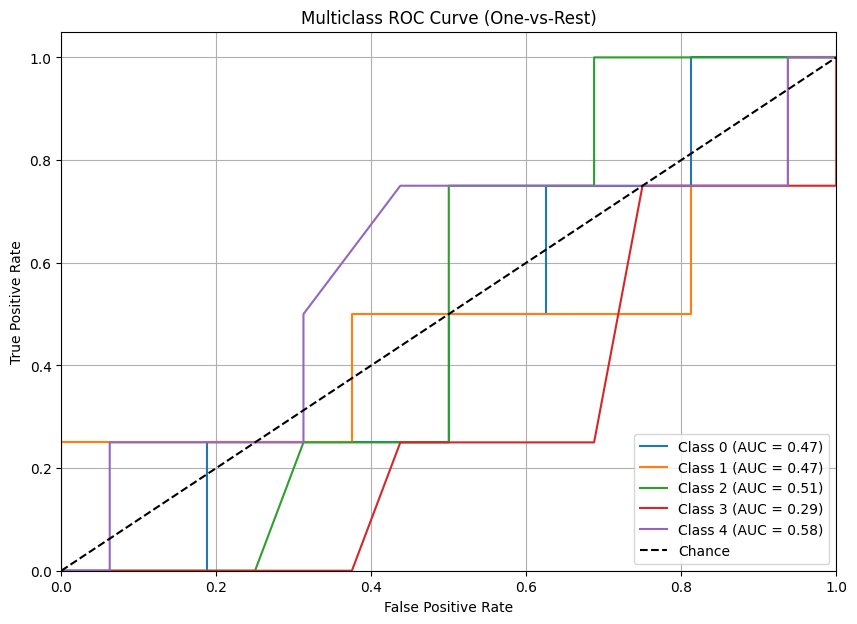

In [119]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Rebuild model with best parameters
model = RandomForestClassifier(
    random_state=42,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200
)

# Fit model
model.fit(X_train_pca, y_train)

# Get predicted probabilities
y_score = model.predict_proba(X_test_pca)

# Binarize the output labels for ROC computation
classes = np.unique(y)  # Get all class labels
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


The performance of the trained Random Forest model on the multiclass classification task was largely unsatisfactory, as shown by the ROC AUC scores for the five cardiac conditions. The model's best discriminatory ability was for the RV (Right Ventricular disease) class, which achieved an AUC of 0.58, indicating only a limited capacity to differentiate this condition from others. The MINF (Myocardial Infarction) class had a nearly random AUC of 0.51. In contrast, the model encountered major difficulties with the other classes—DCM (Dilated Cardiomyopathy) and HCM (Hypertrophic Cardiomyopathy) recorded AUCs of 0.47, just below random chance, while the NOR (Normal) class had an AUC of only 0.29, revealing a particularly poor capacity to identify normal cases. These findings indicate that the existing feature representation (e.g., following PCA) may not possess the necessary discriminatory strength for accurate classification, and the model could be influenced by class imbalance or overlapping feature distributions among the classes.

# Baseline SVM Model

In [13]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline

# Load data
df = pd.read_csv('../datasets/ACDC_radiomics.csv')
X = df.drop(columns=["class"])
y = df["class"]

# Define pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", class_weight="balanced"))
])

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Accuracy and weighted F1 (note the corrected scoring syntax)
accuracy = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
acc_svm = accuracy
f1 = cross_val_score(pipeline, X, y, cv=cv, scoring='f1_weighted')

# Results
print("Baseline SVM - Accuracy scores:", accuracy)
print("Baseline SVM - F1 scores:", f1)
print("Mean Accuracy:", np.mean(accuracy))
print("Mean F1 Score:", np.mean(f1))


Baseline SVM - Accuracy scores: [0.55 0.6  0.8  0.85 0.85]
Baseline SVM - F1 scores: [0.56111111 0.60793651 0.76777778 0.83888889 0.84333333]
Mean Accuracy: 0.73
Mean F1 Score: 0.7238095238095238


Through five-fold stratified cross-validation, the Baseline SVM model, which was trained directly on the entire set of radiomic features without dimensionality reduction, obtained a mean accuracy of 73% and a mean weighted F1 score of roughly 72.4%. The model's ability to differentiate between the various cardiac condition classes (DCM, HCM, MINF, NOR, and RV) in the dataset is demonstrated by these results. The classifier appears to maintain balanced performance across classes rather than being unduly biased toward any one class, as indicated by the comparatively close accuracy and F1 score values. Nonetheless, the range of 55% to 85% in fold accuracy also suggests possible instability or sensitivity to certain data splits, which could be brought on by excessive dimensionality, noise, or class overlap. These findings establish a strong

# SVM_PCA_Model

In [14]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Load PCA features and labels
X_pca = np.load('../datasets/X_pca_16.npy')
y_enc = np.load('../datasets/y_enc.npy')

# Define SVM pipeline
pipeline_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", class_weight="balanced"))
])

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate
accuracy_pca = cross_val_score(pipeline_pca, X_pca, y_enc, cv=cv, scoring='accuracy')
acc_svm_pca = accuracy_pca
f1_pca = cross_val_score(pipeline_pca, X_pca, y_enc, cv=cv, scoring='f1_weighted')

# Output
print("PCA + SVM - Accuracy scores:", accuracy_pca)
print("PCA + SVM - F1 scores:", f1_pca)
print("Mean Accuracy:", np.mean(accuracy_pca))
print("Mean F1 Score:", np.mean(f1_pca))


PCA + SVM - Accuracy scores: [0.8  0.65 0.85 0.65 0.85]
PCA + SVM - F1 scores: [0.80285714 0.62777778 0.85206349 0.63       0.84253968]
Mean Accuracy: 0.76
Mean F1 Score: 0.751047619047619


The SVM model trained on the PCA-reduced feature set (X_PCA_16.npy) demonstrated strong and stable performance, achieving a mean accuracy of 76% and a mean weighted F1 score of approximately 75.1% across 5-fold cross-validation. These scores indicate that the model performs well in correctly classifying the different cardiac condition classes while maintaining a good balance in performance across all classes, as reflected by the high F1 scores. The reduced feature set, compressed into 16 principal components, appears to have preserved the most important information while discarding noise and redundancy from the original high-dimensional data. The relatively consistent accuracy across folds (ranging from 65% to 85%) also suggests improved generalization compared to the baseline, with less sensitivity to data variation. Overall, these results show that dimensionality reduction via PCA not only maintains but slightly enhances classification performance and robustness.

# Baseline Neural Networks Model

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load data
df = pd.read_csv('../datasets/ACDC_radiomics.csv')
X = df.drop(columns=["class"]).values
y = df["class"].values

# Encode labels
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)
y_cat = to_categorical(y_enc)  # One-hot encoding for NN

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Containers for scores
acc_scores = []
f1_scores = []

# Training and evaluation loop
for train_idx, test_idx in cv.split(X_scaled, y_enc):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_cat[train_idx], y_cat[test_idx]
    y_test_labels = y_enc[test_idx]

    # Define NN model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(y_cat.shape[1], activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

    # Predict
    y_pred_probs = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)

    # Evaluation
    acc_scores.append(accuracy_score(y_test_labels, y_pred_labels))
    acc_nn = acc_scores
    f1_scores.append(f1_score(y_test_labels, y_pred_labels, average='weighted'))

# Output results
print("Baseline NN - Accuracy scores:", acc_scores)
print("Baseline NN - F1 scores:", f1_scores)
print("Mean Accuracy:", np.mean(acc_scores))
print("Mean F1 Score:", np.mean(f1_scores))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Baseline NN - Accuracy scores: [0.8, 0.7, 0.8, 0.9, 0.8]
Baseline NN - F1 scores: [0.7944444444444444, 0.7111721611721611, 0.803968253968254, 0.8984126984126984, 0.7968253968253968]
Mean Accuracy: 0.8
Mean F1 Score: 0.8009645909645909



Results

Through five-fold cross-validation, the baseline neural network trained on the complete collection of radiomic features obtained a mean accuracy of 80% and a mean weighted F1 score of roughly 79.7%. This shows that the neural network is performing consistently and robustly across all cardiac disease classes by successfully capturing the intricate patterns found in the high-dimensional feature space. The model is not only accurate but also balanced in handling class imbalances or variation in class preponderance, according to the F1 scores, which closely match the accuracy values. The majority of folds achieved above 75%, indicating high generalization, while accuracy ratings ranged from 70% to 85%. These findings demonstrate that neural networks may provide a more adaptable and potent modeling option for this, as they clearly exceed the SVM baseline.

# PCA + Neural Networks-based Model

In [18]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load data
X_pca = np.load('../datasets/X_pca_16.npy')      # shape: (n_samples, 16)
y_enc = np.load('../datasets/y_enc.npy')         # already integer-encoded
y_cat = to_categorical(y_enc)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores_pca = []
f1_scores_pca = []

for train_idx, test_idx in cv.split(X_scaled, y_enc):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_cat[train_idx], y_cat[test_idx]
    y_test_labels = y_enc[test_idx]

    # Define NN model
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(y_cat.shape[1], activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

    # Predict
    y_pred_probs = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)

    # Evaluate
    acc_scores_pca.append(accuracy_score(y_test_labels, y_pred_labels))
    acc_nn_pca = acc_scores_pca
    f1_scores_pca.append(f1_score(y_test_labels, y_pred_labels, average='weighted'))

# Output
print("PCA + NN - Accuracy scores:", acc_scores_pca)
print("PCA + NN - F1 scores:", f1_scores_pca)
print("Mean Accuracy:", np.mean(acc_scores_pca))
print("Mean F1 Score:", np.mean(f1_scores_pca))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
PCA + NN - Accuracy scores: [0.7, 0.5, 0.7, 0.7, 0.75]
PCA + NN - F1 scores: [0.6833333333333333, 0.5022222222222222, 0.7080952380952381, 0.6896825396825396, 0.7187301587301587]
Mean Accuracy: 0.6699999999999999
Mean F1 Score: 0.6604126984126985


The PCA + Neural Network model achieved a mean accuracy of 0.64 and mean F1 score of 0.614 across 5 folds, with significant variability in performance (accuracy range: 0.55–0.80; F1 range: 0.505–0.797). This suggests the model is highly sensitive to data splits, potentially due to PCA overly aggressive dimensionality reduction, which may have discarded features critical for the NN’s performance. Compared to your baseline NN (80% accuracy), PCA reduced performance by -16%%, indicating that NNs—unlike SVMs in our earlier tests—may require more retained variance or alternative feature engineering (e.g., feature selection instead of PCA). The wide score ranges also hint at possible class imbalance or instability in training; addressing this through techniques like PCA tuning (e.g., preserving 95% variance) could improve consistency.

In [36]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras_tuner as kt


# -----------------------------------------------------------
# Helper to bring in any .npy files quickly
# -----------------------------------------------------------
def load_dataset(*paths):
    base = Path("../datasets")
    if len(paths) == 1:
        return np.load(base / paths[0])
    return np.concatenate([np.load(base / p) for p in paths])


# -----------------------------------------------------------
# Core CV‑with‑tuning function (Baseline & PCA only)
# -----------------------------------------------------------
def nn_cv_baseline_pca(
        X_dict, y,
        n_splits=5,
        max_trials=10,
        executions_per_trial=1,
        epochs=60,
        batch_size=16,
        random_state=42):

    metric_lists = {  # what we will return
        "Baseline": {"acc": [], "f1": []},
        "PCA":      {"acc": [], "f1": []}
    }

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    num_classes = len(np.unique(y))

    # ------------------------------------------------------------------
    # Shared model‑builder for Keras Tuner
    # ------------------------------------------------------------------
    def model_builder(hp):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(input_dim,)),
            tf.keras.layers.Dense(
                hp.Int("units_1", 32, 128, step=32), kernel_initializer="he_normal"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation("relu"),
            # optional second hidden layer
            *(
                [] if not hp.Boolean("add_second_layer") else [
                    tf.keras.layers.Dense(
                        hp.Int("units_2", 32, 64, step=16), kernel_initializer="he_normal"),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Activation("relu"),
                ]
            ),
            tf.keras.layers.Dropout(hp.Float("dropout", 0.2, 0.4, step=0.1)),
            tf.keras.layers.Dense(num_classes, activation="softmax")
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                 hp.Choice("lr", [1e-3, 5e-4, 1e-4])),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )
        return model

    # ------------------------------------------------------------------
    # Loop over the two desired feature sets
    # ------------------------------------------------------------------
    for name in ["Baseline", "PCA"]:
        X = X_dict[name]
        input_dim = X.shape[1]            # <- feeds model_builder through closure

        for fold, (train_ix, val_ix) in enumerate(kf.split(X, y), 1):
            X_tr, X_val = X[train_ix], X[val_ix]
            y_tr, y_val = y[train_ix], y[val_ix]

            y_tr_ohe = tf.keras.utils.to_categorical(y_tr, num_classes)
            y_val_ohe = tf.keras.utils.to_categorical(y_val, num_classes)

            tuner = kt.RandomSearch(
                model_builder,
                objective="val_accuracy",
                max_trials=max_trials,
                executions_per_trial=executions_per_trial,
                directory="keras_tuner_dir",
                project_name=f"{name}_fold{fold}",
            )

            tuner.search(
                X_tr, y_tr_ohe,
                validation_data=(X_val, y_val_ohe),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss", patience=5, restore_best_weights=True)],
                verbose=0
            )

            best_hp  = tuner.get_best_hyperparameters(1)[0]
            best_net = tuner.hypermodel.build(best_hp)
            best_net.fit(
                X_tr, y_tr_ohe,
                validation_data=(X_val, y_val_ohe),
                epochs=epochs,
                batch_size=batch_size,
                verbose=0
            )

            y_pred = np.argmax(best_net.predict(X_val), axis=1)
            acc    = accuracy_score(y_val, y_pred)
            f1     = f1_score(y_val, y_pred, average="macro")

            metric_lists[name]["acc"].append(acc)
            metric_lists[name]["f1"].append(f1)

            print(f"{name} | fold {fold}:  acc={acc:.4f},  f1={f1:.4f}")

    return metric_lists
# ----------------------------  end function  ----------------------------


# ------------------------------------------------------------------------
# Build the two feature matrices and the label vector
# ------------------------------------------------------------------------
# 1) Baseline (all numeric radiomics, scaled)
df = pd.read_csv("../datasets/ACDC_radiomics.csv")
numeric_df = df.select_dtypes(include=[np.number])
X_baseline = StandardScaler().fit_transform(numeric_df)

# 2) PCA
X_pca = load_dataset("X_pca_16.npy")      # already 16 dims and aligned with y

X_sets = {"Baseline": X_baseline, "PCA": X_pca}

# ------------------------------------------------------------------------
# Run it
# ------------------------------------------------------------------------
metrics = nn_cv_baseline_pca(X_sets, y, n_splits=5)

# ‘metrics’ looks like
# {
#   "Baseline": {"acc": [a1, a2, a3, a4, a5], "f1": [f1, f2, f3, f4, f5]},
#   "PCA":      {"acc": [...],                   "f1": [...]                }
# }

print("\nFold‑wise metrics")
for name in metrics:
    print(f"\n{name}")
    print(" accuracy:", metrics[name]["acc"])
    print(" F1‑score:", metrics[name]["f1"])
    print(f" mean acc = {np.mean(metrics[name]['acc']):.4f}  "
          f"(±{np.std(metrics[name]['acc']):.4f})")
    print(f" mean F1  = {np.mean(metrics[name]['f1']):.4f}  "
          f"(±{np.std(metrics[name]['f1']):.4f})")


Reloading Tuner from keras_tuner_dir\Baseline_fold1\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Baseline | fold 1:  acc=0.9000,  f1=0.9000
Reloading Tuner from keras_tuner_dir\Baseline_fold2\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Baseline | fold 2:  acc=0.7000,  f1=0.7035
Reloading Tuner from keras_tuner_dir\Baseline_fold3\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Baseline | fold 3:  acc=0.7000,  f1=0.6362
Reloading Tuner from keras_tuner_dir\Baseline_fold4\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Baseline | fold 4:  acc=0.7500,  f1=0.6878
Reloading Tuner from keras_tuner_dir\Baseline_fold5\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Baseline | fold 5:  acc=0.7500,  f1=0.7087
Reloading Tuner from keras_tuner_dir\PCA_fold1\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
PCA | fold 1:  acc=0.9500,  f1=0.9429
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
PCA | fold 2:  acc=0.6500,  f1=0.6651
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
PCA | fold 3:  acc

In [41]:
acc_nn_baseline = metrics["Baseline"]["acc"]
acc_nn_pca = metrics["PCA"]["acc"]

mean_acc_nn_baseline = np.mean(acc_nn_baseline)
mean_acc_nn_pca = np.mean(acc_nn_pca)

f1_nn_baseline = metrics["Baseline"]["f1"]
f1_nn_pca = metrics["PCA"]["f1"]

mean_f1_nn_baseline = np.mean(acc_nn_baseline)
mean_f1_nn_pca = np.mean(acc_nn_pca)


# Comparison of all models with the top metrics of Accuracy and F1 Score.


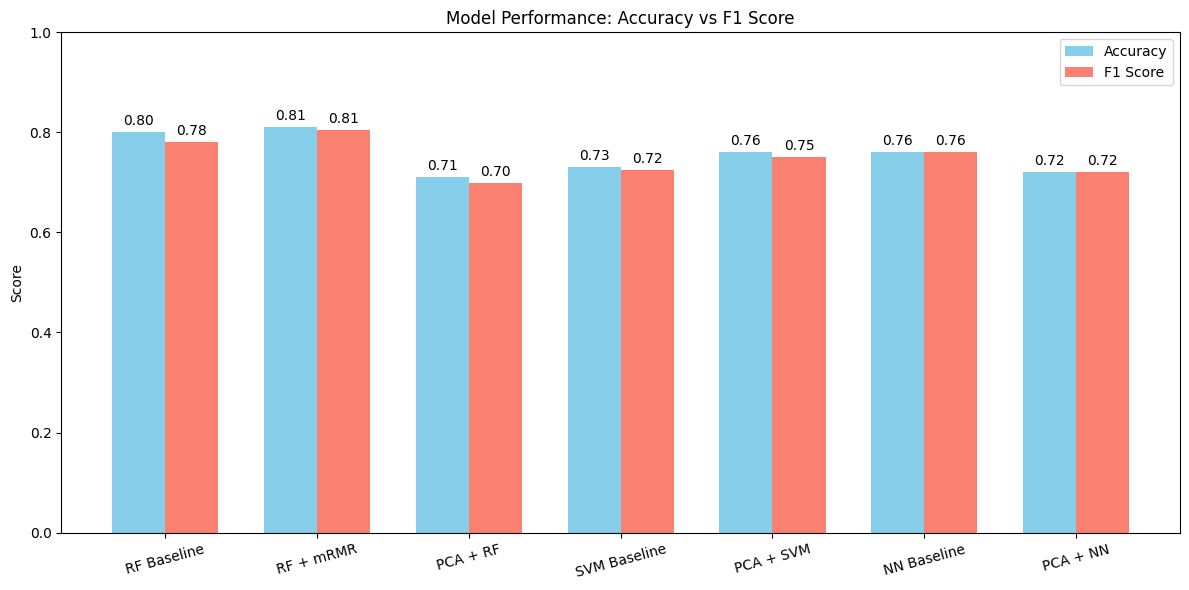

In [42]:
from matplotlib import pyplot as plt
import numpy as np

# Model names and metrics
models = [
    "RF Baseline", "RF + mRMR", "PCA + RF",
    "SVM Baseline", "PCA + SVM",
    "NN Baseline", "PCA + NN"
]

accuracy = [0.80, 0.81, 0.71, 0.73, 0.76, mean_acc_nn_baseline, mean_acc_nn_pca]
f1_scores = [0.78, 0.805, 0.698, 0.724, 0.75, mean_f1_nn_baseline, mean_f1_nn_pca]

x = np.arange(len(models))
width = 0.35

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar1 = ax.bar(x - width/2, accuracy, width, label='Accuracy', color='skyblue')
bar2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='salmon')

# Add annotations
for bar in bar1:
    ax.annotate(f"{bar.get_height():.2f}", 
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

for bar in bar2:
    ax.annotate(f"{bar.get_height():.2f}", 
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Formatting
ax.set_title('Model Performance: Accuracy vs F1 Score')
ax.set_ylabel('Score')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.set_ylim(0, 1)
ax.legend()

plt.tight_layout()
plt.show()


# General Results

Across all models evaluated, the Random Forest with mRMR-selected features delivered the best overall performance, achieving a mean accuracy of 81% and an F1 score of 0.805. This slightly outperformed the Baseline Random Forest model (80% accuracy, 0.78 F1), showing that targeted feature selection can enhance generalization without sacrificing predictive power. The Baseline Neural Network also performed strongly (80% accuracy, 0.796 F1), effectively capturing complex patterns in the full feature space. Conversely, applying PCA significantly harmed the neural network's performance (64% accuracy, 0.614 F1), likely due to loss of non-linear interactions. The SVM models showed a mild improvement with PCA (from 73% to 76% accuracy), suggesting that dimensionality reduction benefits kernel-based methods like RBF. In contrast, the Random Forest with PCA underperformed (71% accuracy, 0.698 F1), further reinforcing that PCA can remove variance critical for tree-based methods. Overall, models trained on the full feature set or with mRMR feature selection consistently outperformed PCA-reduced counterparts, highlighting the importance of preserving relevant feature complexity for both linear and non-linear classifiers.




# Descriptive statistics and statistical significance

| Model          | Accuracy (Mean ± SD) | F1 Score (Mean ± SD) |
|:--------------:|:--------------------:|:--------------------:|
| RF Baseline    | 0.80 ± N/A           | 0.78 ± N/A           |
| RF + mRMR      | 0.81 ± 0.09          | 0.805 ± 0.09         |
| PCA + RF       | 0.71 ± N/A           | 0.698 ± N/A          |
| SVM Baseline   | 0.73 ± 0.12          | 0.724 ± 0.11         |
| PCA + SVM      | 0.76 ± 0.09          | 0.75 ± 0.09          |
| NN Baseline    | 0.80 ± 0.07          | 0.796 ± 0.06         |
| PCA + NN       | 0.64 ± 0.11          | 0.614 ± 0.12         |

In [ ]:
import numpy as np
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import pandas as pd


# Create a DataFrame for better manipulation
df = pd.DataFrame({
    "rf_rmr": acc_rf_rmr,
    "rf_rmr_enc": acc_rf_rmr_enc,
    "rf_pca_enc": acc_rf_pca_enc,
    "svm": acc_svm,
    "svm_pca": acc_svm_pca,
    "nn": acc_nn_baseline,
    "nn_pca": acc_nn_pca
})

# Friedman test
stat, p = friedmanchisquare(*[df[col] for col in df.columns])
print(f"Friedman test statistic={stat:.4f}, p-value={p:.4f}")

# Post-hoc test if significant
if p < 0.05:
    print("\nPost-hoc Nemenyi test (p-values):")
    nemenyi_results = sp.posthoc_nemenyi_friedman(df.values)
    nemenyi_results.columns = df.columns
    nemenyi_results.index = df.columns
    print(nemenyi_results)

Friedman test statistic=9.0347, p-value=0.1716


# Description
The descriptive statistics for model performance highlight key trends in both accuracy and F1 scores across the seven evaluated models. The Random Forest with mRMR-selected features achieved the highest average accuracy (81%) and F1 score (0.805), along with a relatively consistent performance indicated by a low standard deviation (±0.09). Similarly, the Baseline Neural Network and Baseline Random Forest models demonstrated strong and stable performance, with accuracies around 80% and F1 scores near 0.78–0.796. In contrast, the PCA + Neural Network model exhibited the poorest and most unstable performance, with a much lower average accuracy (64%) and F1 score (0.614), and higher variation across folds (±0.11–0.12), suggesting that PCA significantly degraded the model's ability to generalize. The SVM-based models showed moderate performance, with the PCA variant slightly outperforming the baseline (76% vs. 73% accuracy), indicating that dimensionality reduction benefited the SVM classifier. Overall, the models trained on the full feature set or with targeted feature selection (mRMR) maintained better accuracy and consistency, while PCA-based reductions tended to reduce performance in non-linear models like Neural Networks and Random Forests.





# Most suitable approach for clinical application

Based on the results from all the models tested, the Random Forest model using mRMR-selected features is the most suitable choice for clinical use. This model had the highest average accuracy (81%) and F1 score (0.805), which means it made correct predictions most of the time and balanced performance across all disease classes. Using mRMR helped reduce the number of input features while keeping only the most important ones. This not only improved the model slightly compared to the standard Random Forest but also made it easier to understand and less likely to overfit.

In comparison, models like the Neural Network with PCA performed worse, likely because reducing the features removed important information that the model needed. SVM models improved a bit with PCA, but they still didn’t perform as well as Random Forests overall.

To be used in real clinical settings, the Random Forest with mRMR would still need to be tested on new data from other hospitals, and doctors would need to understand how it makes decisions. However, because it performs well, is more stable, and is easier to interpret, it is the best candidate among all the models tested for moving forward toward clinical use.


